<h1 style="font-size:30px;">Image Classification using Feedforward Networks in Keras</h1>

In this notebook, we will introduce several new concepts associated with the general problem of classification involving more than two classes. This is sometimes referred to as multinomial regression or softmax regression when the number of classes is more than two. Specifically, we will see how to classify hand-written digits from the MNIST dataset using a feed-forward Multilayer Perceptron Network. MLPs are not the preferred way to process image data, but this serves as a good example to introduce some new concepts. The MNIST hand-written digit dataset is included in Tensorflow and can easily be imported and loaded, as we will see below. Using this dataset and a simple feed-forward network, we will demonstrate one approach for how to work with image data and build a network that classifies digits `[0,9]`.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-mnist-digits-classification.png' width=800 align='center'>

## Table of Contents
* [1 Load the MNIST Dataset](#1-Load-the-MNIST-Dataset)
* [2 Dataset Preprocessing](#2-Dataset-Preprocessing)
* [3 Model Architecture](#3-Model-Architecture)
* [4 Model Implementation](#4-Model-Implementation)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["image.cmap"] = "gray"

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 1 Load and Split the MNIST Dataset

The MNIST dataset contains 70,000 images partitioned into 60,000 for training and 10,000 for test. Reserving a portion of the data for validation can be accomplished by further partitioning the training data. As shown below, we carve out 10,000 samples from the training data to use for validation.

In [16]:
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

X_valid = X_train_all[:10000]
X_train = X_train_all[10000:]

y_valid = y_train_all[:10000]
y_train = y_train_all[10000:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [17]:
X_train[0].shape

(28, 28)

In [18]:
X_train.shape[0]

50000

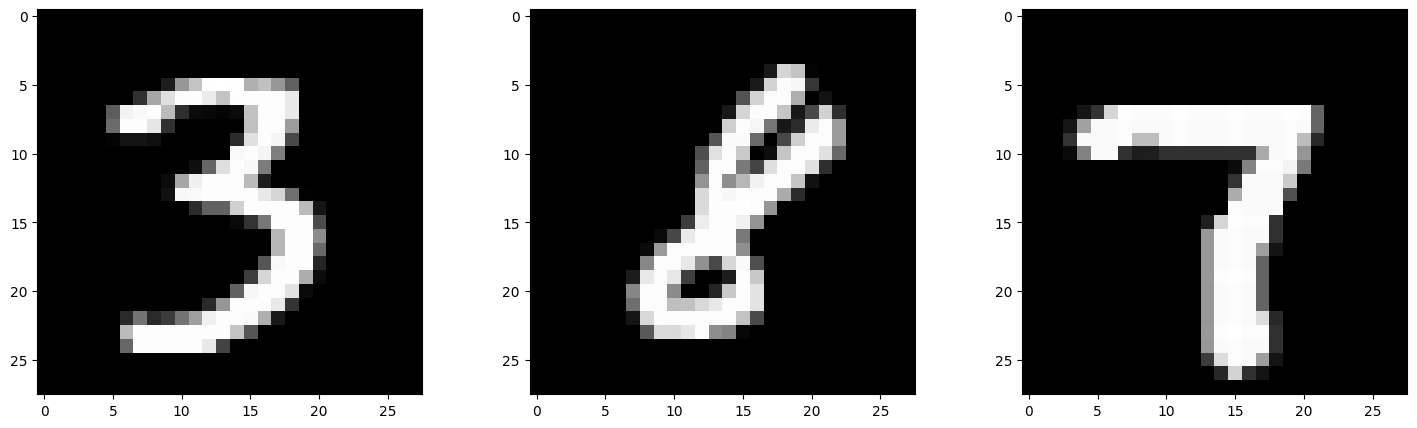

In [19]:
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis(True)
    plt.imshow(X_train[i], cmap="gray")
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

## 2 Dataset Preprocessing

### 2.1 Input Feature Transformation and Normalization

Since we are now working with images as the input, we need to find some logical way to represent the image data as a set of features. A naive approach that actually works fairly well for this dataset is to just assume that the pixel intensities **are** the features. And one way to transform the image data into a set of features that we can process is to flatten the 2D array into a 1D array. The `28x28` input image thus becomes a 1D array containing 784 features. Notice that we also normalize the pixel intensities to be in the range `[0, 1]`. This is very common when working with image data which helps the model train more efficiently. Also, just to be clear, using the pixel intensities as features is a naive approach that we are using intentionally here to keep things simple. As we will see in subsequent posts, we will learn about convolutional neural networks (CNNs), which use more advanced techniques for representing and processing image data in neural networks.


In [20]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test = X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
X_valid = X_valid.astype("float32") / 255

### 2.2 Label Encoding Options

When working with categorical data, the target labels need to be represented as numerical values prior to processing the data through machine learning algorithms. Label encoding is the process of converting class labels from strings to numerical values. We have a couple of options for how to numerically encode the labels for each class. We can use ordinal **integer encoding**, where an integer is assigned to each class, or we can use a technique called **one-hot encoding**, which uses a separate binary vector to encode each class label. Depending on the dataset, one approach might be preferred over the other, but for most situations, one-hot encoding is often used. Since this is an introductory post, we will briefly demonstrate what each encoding looks like so you are familiar with both representations.

In [21]:
X_train.shape

(50000, 784)

### 2.2.1 Integer Label Encoding

Datasets that contain categorical labels may represent the labels internally as strings or as integers. However, prior to processing the dataset through a neural network, the labels must have a numerical representation. When the dataset contains integer labels for categorical data, a class label file is provided that defines the mapping from class names to their integer representations in the dataset so the integers can be mapped back to class names when needed. As a concrete example, consider the dictionary mapping shown below for the Fashion MNIST dataset.

```html
Label	Description
0	    T-shirt/top
1	    Trouser
2	    Pullover
3	    Dress
4	    Coat
5	    Sandal
6	    Shirt
7	    Sneaker
8	    Bag
9	    Ankle boot
```

The Fashion MNIST dataset itself contains the integer labels which we can verify this by loading the dataset and printing out some of the labels as shown in the output from the code cell below. This type of label encoding is called **Integer Encoding** because unique integers are used to encode the class (string) labels. However, when the class labels have no relationship to one another, it is often recommended that **One-Hot Encoding** is used instead, which is described in the next section.

In [22]:
# Load the Fashion MNIST dataset.
((X_train_fashion, y_train_fashion), (_, _)) = fashion_mnist.load_data()

# The labels in the Fashion MNIST dataset are encoded as integers.
print(y_train_fashion[0:9])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[9 0 0 3 0 2 7 2 5]


### 2.2.2 One-Hot Label Encoding
One-hot encoding is a technique that represents categorical labels as one-hot encoded vectors. So rather than representing the class labels as unique integers, we can represent each label as a binary vector using the `to_categorical()` function in Keras as a pre-processing step. In this case, each label is converted to a binary vector where the length of the vector is equal to the number of classes. All entries are set to zero except for the element that corresponds to the integer label.

In [23]:
y_train_onehot = to_categorical(y_train_fashion[0:9])
print(y_train_onehot)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


**Note**: Since the labels from the **MNIST digit** dataset have integer labels that correspond directly to the class labels (i.e., integer `4` corresponds to the class label `4`), there is technically no need for a class mapping file. And further, since the integer labels have a natural ordering, we can use the integer labels directly. But since one-hot encoding is most often used, we will proceed with encoding the labels this way, as shown below.

In [24]:
# Convert integer labels to one-hot encoded vectors.
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test  = to_categorical(y_test)

## 3 Model Architecture

### 3.1 Deep Neural Network Architecture

The network architecture shown below has multiple layers. An input layer, two hidden layers, and an output layer. There are several things to note about this architecture.

1. **Input Data**: The image input data is pre-processed (flattened) from a 2-Dimensional array `[28x28]` to 1-Dimensional vector of length `[784x1]` where the elements in this input vector are the normalized pixel intensities. The input to the network is sometimes referred to as the input "layer", but it's not technically a layer in the network because there are no trainable parameters associated with it.
2. **Hidden Layers**: We have two hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc...).
3. **Output Layer**: We now have ten neurons in the output layer to represent the ten different classes (digits: 0 to 9), instead of a single neuron as in the regression example.
4. **Dense Layers**: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The **weights** associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.
5. **Softmax Function**: The values from each of the neurons in the output layer are pased through a **softmax** function to produce a probability score for each of the ten digits in the dataset.

6. **Network Output**: The network output ($y’$), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing ($y'$) through the `argmax` function to determine the index of the predicted label.
6. **Loss Function**: The loss function used is **Cross Entropy Loss**, which is generally the preferred loss function for classification problems. It is computed from the ground truth labels ($y$) and the output probabilities of the network ($y'$). Note that $y$ and $y'$ are both vectors whose length is equal to the number of classes.

Although the diagram looks quite a bit different from the single-layer perceptron in the linear regression example, it is fundamentally very similar in terms of the processing that takes place during training and prediction. We still compute a loss based on the predicted output of the network and the ground truth label of the inputs. Backpropagation is used to compute the gradient of the loss with respect to the weights in the network. An optimizer (which implements gradient descent) is used to update the weights in the neural network.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-mnist-mlp-network.png' align='center' width='1000'>

## 4 Model Implementation

Here we use Keras to define the model architecture, which has two dense layers (each with 128 neurons) and a single output layer with 10 neurons. Each neuron in the output layer corresponds to a class label from the dataset (0 through 9) where the output of each represents the probability that the input image corresponds to the class associated with that neuron. For example, if the output from the 5th neuron is .87, then that means the probability that the input image is a 4 is 87% (since the first class is 0, the 5th neuron represents the digit `4`).

Notice that the first hidden layer has an input shape of [784,1] since the 28x28 image is flattened to a vector of length 784. The neurons in each of the hidden layers have activation functions called "ReLU" which stands for Rectified Linear Unit. The neurons in the output layer are then passed through a "softmax" function which transforms (normalizes) the raw output, which can be interpreted as a probability as described above.

We will not cover the details of the softmax function or the cross entropy loss function in this post as these are more advanced topics and will be deferred to a post, but briefly, the softmax function normalizes the outputs from the network and converts them to probabilities. The cross-entropy loss function computes a loss between the predicted output probabilities and the ground truth labels. The further the predicted output probabilities are from the target labels the higher the loss.


### 4.1 Define the Model

In [28]:

X_train.shape[0],X_train.shape[1]

(50000, 784)

In [25]:
# Instantiate the model.
model = tf.keras.Sequential()

# Build the model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

# Display the model summary.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Compile the Model

This step defines the optimizer and the loss function that will be used in the training loop. This is also where we can specify any additional metrics to track.

**Optimizer**: Here, we will use the RMSProp optimizer in Keras.

**Loss Function**: As mentioned above, the preferred loss function for classification problems is **Cross Entropy**. But depending on how the labels are encoded we’ll need to specify the proper form of the cross entropy loss function. If the labels are one-hot encoded, then you should specify the loss function as `categorical_crossentropy`, and if the labels are integer encoded, then you should use `sparse_categorical_crossentropy`. When performing binary classification, you should use `binary_crossentropy` as the loss function. Since we are using one-hot encoding in this example, we will specify the loss function as `categorical_crossentropy`.

**Metrics**: Finally, we also specify `accuracy` as an additional metric to record during training so that we can plot it after training is completed. The training loss and validation loss are automatically recorded, so there is no need to specify those.

In [29]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

### 4.3 Train the Model
To train the model we call the `fit()` method in Keras. Notice that since we split the original training data into train and validation components, we need to explicitly specify the validation dataset using `validation_data=(X_valid, y_valid))`. Recall from an ealier post in this series on linear regression, that we also have the option to use the `validation_split` argument to automatically withhold a random portion of the training data for use as the validation data. So here, we're demonstrating how to explicitly use a separate validation dataset.

In [30]:
training_results = model.fit(X_train,
                             y_train,
                             epochs=21,
                             batch_size=64,
                             validation_data=(X_valid, y_valid));

Epoch 1/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8643 - loss: 0.4780 - val_accuracy: 0.9450 - val_loss: 0.1755
Epoch 2/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9601 - loss: 0.1360 - val_accuracy: 0.9606 - val_loss: 0.1299
Epoch 3/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9746 - loss: 0.0894 - val_accuracy: 0.9646 - val_loss: 0.1131
Epoch 4/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9818 - loss: 0.0646 - val_accuracy: 0.9688 - val_loss: 0.1094
Epoch 5/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9861 - loss: 0.0489 - val_accuracy: 0.9727 - val_loss: 0.1086
Epoch 6/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9900 - loss: 0.0369 - val_accuracy: 0.9721 - val_loss: 0.1184
Epoch 7/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9927 - loss: 0.0288 - val_accuracy: 0.9723 - val_loss: 0.1228
Epoch 8/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9932 - loss: 0.0242 - val_accuracy: 0.

## 4.4 Plot the Training Results

The function below is a convenience function to plot training and validation losses and training and validation accuracies. It has a single required argument which is a list of metrics to plot.

In [31]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 20])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

The loss and accuracy metrics can be accessed from the `history` object returned from the fit method. We access the metrics using predefined dictionary keys as shown below.  

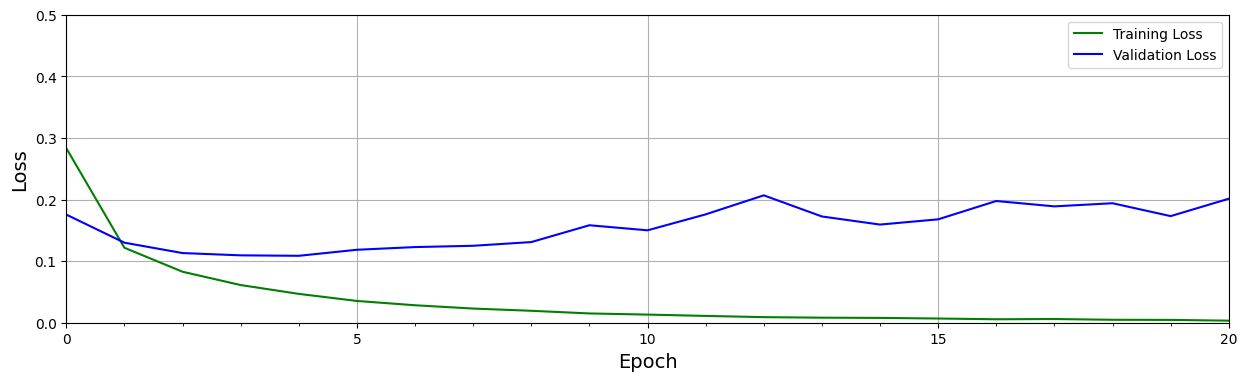

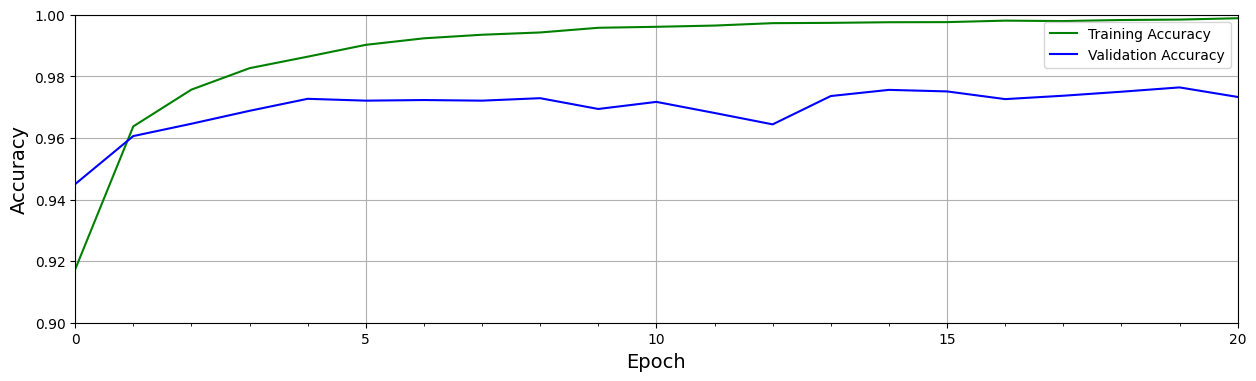

In [32]:

# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 0.5],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.9, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

## 5 Model Evaluation

### 5.1 Make Predictions on Sample Test Images
We can now predict the results for all the test images, as shown in the code below. Here, we call the `predict()` method to retrieve all the predictions, and then we select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [33]:
predictions = model.predict(X_test)
index = 0  # up to 9999
print("Ground truth for test digit: ", y_test[index])
print("\n")
print("Predictions for each class:\n")
for i in range(10):
    print("digit:", i, " probability: ", predictions[index][i])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ground truth for test digit:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Predictions for each class:

digit: 0  probability:  2.684698e-22
digit: 1  probability:  9.692276e-20
digit: 2  probability:  9.946276e-17
digit: 3  probability:  4.6670663e-16
digit: 4  probability:  1.8910179e-23
digit: 5  probability:  6.748138e-24
digit: 6  probability:  7.511793e-33
digit: 7  probability:  1.0
digit: 8  probability:  6.109522e-23
digit: 9  probability:  1.0868286e-14


### 5.2 Confusion Matrix

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix in TensorFlow is accomplished by calling the function `tf.math.confusion_matrix()`, which takes two required arguments which are the list of ground truth labels and the associated predicted lables.

In [34]:
# Generate predictions for the test dataset.
predictions = model.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


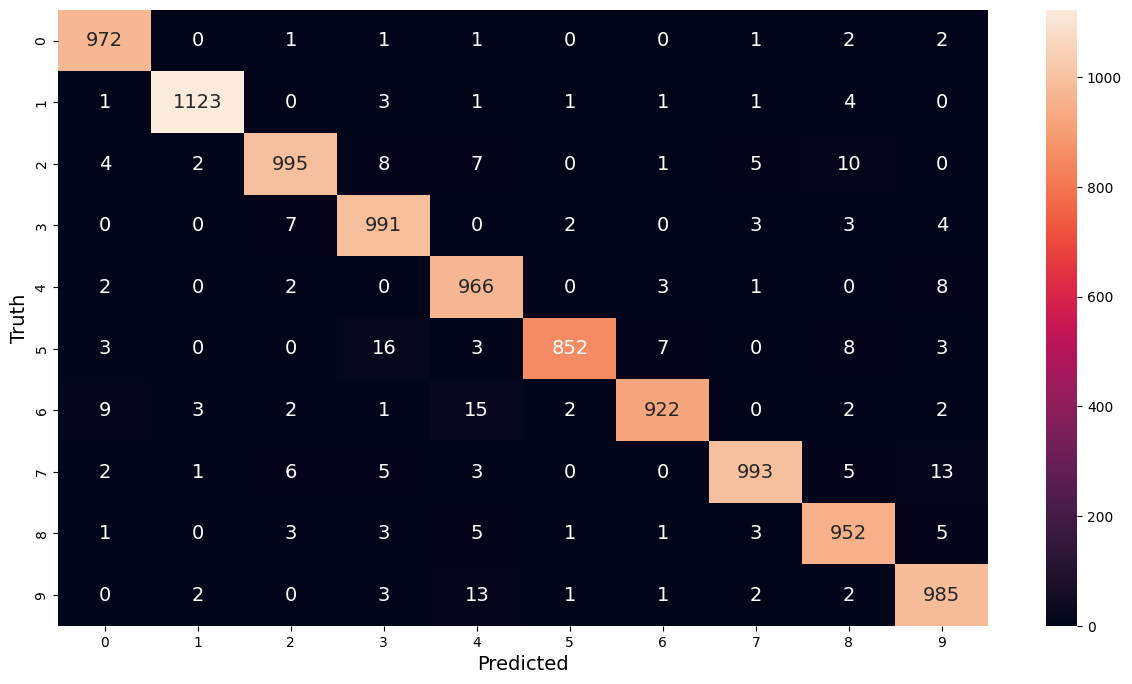

In [35]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn

sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

### 6. Conclusions

In this notebook, we introduced a simple approach for how to model image data for use in a densely connected network to perform multinomial classification. In the next notebook, we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well-known CNN architectures, which is a great place to start getting familiar with them.

https://tensorspace.org/html/playground/lenet.html